# Demonstration of Video Gait Analysis

In this notebook we present how to run OpenPose processing on a video and how apply neural networks from the paper to data processed by OpenPose. As a result, for a given mp4 file we will get predictions from all models.

To run this script you will need packages from the file `requirements.txt`. To install requirements run:
```bash
pip install -r requirements.txt
```
we recommend using conda or a virtual environment.

We start with some definitions and global constants.

In [1]:
import pandas as pd
import numpy as np
import os
import json
from video_process_utils import *
from keras.models import load_model
import keras.losses
import keras.metrics
keras.losses.loss = keras.losses.mse
keras.metrics.loss = keras.metrics.mse
from IPython.display import Video
from statsmodels.regression.linear_model import OLSResults

Using TensorFlow backend.


## Collect data

Record a video of gait from the side. To achieve best results:
* Camera should be placed 4 meters from the line of walking
* Ask the person to walk straight from the right to the left (looking from the camera perspective)
* Make sure there are no other people in the background
* If the line of walking is short, ask them to turn at the end and go back
* Record in potrait mode
* Follow the person by rotating the camera set in the same place
* Save the video as mp4 at 30 frames per second

See an example video below.

## Run openpose

In order to run openpose on your video, save your video as `input.mp4` in the `in` directory of this repository. You only need NVIDIA docker installed in your system -- OpenPose will be downloaded automatically.

For convenience, we added an example video to `in` directory.

In [2]:
Video("in/input.mp4")

To run OpenPose simply use
```bash
bash run_openpose.sh
```
Results of OpenPose will be saved in `out` directory. The folder will contain your video with an OpenPose overlay and json output in `keypoints` subdirectory. Here is an example from the test file:

In [3]:
Video("out/video.mp4")

## Processing the output

Next, we need to process OpenPose output to the format accepted by our neural networks. This will include:

* processing json files to create a data matrix,
* intrapolating signals,
* scaling (normalizing) observations.

First, we convert JSON output to a data matrix

In [4]:
def convert_json2csv(json_dir):
    resL = np.zeros((300,75))
    resL[:] = np.nan
    for frame in range(1,300):
        test_image_json = '%sinput_%s_keypoints.json' %\
            (json_dir, str(frame).zfill(12))

        if not os.path.isfile(test_image_json):
            break
        with open(test_image_json) as data_file:  
            data = json.load(data_file)

        for person in data['people']:
            keypoints = person['pose_keypoints_2d']
            xcoords = [keypoints[i] for i in range(len(keypoints)) if i % 3 == 0]
            counter = 0
            resL[frame-1,:] = keypoints
            break

    #we can save space by dropping rows after the last row that isn't all nan
    check = np.apply_along_axis(lambda x: np.any(~np.isnan(x)),1,resL)
    for i in range(len(check)-1,-1,-1):
        if check[i]:
            break
    return resL[:i+1]

In [5]:
frames = convert_json2csv("out/keypoints/")
pd.DataFrame(frames)

,0,1,2,3,4,5,6,7,8,9,...,65,66,67,68,69,70,71,72,73,74
0,121.921,91.2449,0.847875,161.962,133.874,0.775835,153.912,132.628,0.662659,184.620,...,0.784260,41.8747,419.452,0.648937,47.1902,416.801,0.600408,89.8410,431.410,0.754443
1,121.886,93.9273,0.631822,161.928,133.936,0.766678,153.899,133.923,0.652227,184.633,...,0.762319,40.5227,422.077,0.652347,45.8460,420.768,0.606026,89.8963,432.833,0.758049
2,121.878,97.8725,0.607743,159.277,133.998,0.775083,149.940,133.984,0.674706,181.940,...,0.713570,47.1821,431.450,0.663973,48.5470,430.080,0.599336,97.8752,434.113,0.724553
3,121.870,99.1929,0.453752,156.634,135.243,0.768227,145.949,135.252,0.667979,179.284,...,0.831985,53.8504,435.484,0.569884,56.5374,432.796,0.550346,104.5930,432.869,0.739742
4,119.249,91.1830,0.666602,157.934,133.931,0.766300,148.621,133.909,0.661712,0.000,...,0.756713,65.8701,442.106,0.670542,68.5369,438.122,0.588460,113.9470,432.813,0.784611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,208.665,80.5851,0.747435,164.659,123.217,0.862943,175.280,123.208,0.831017,178.003,...,0.798120,168.6040,451.463,0.704251,160.5970,452.861,0.691107,117.9180,444.839,0.790635
295,207.352,85.8944,0.808471,164.628,123.286,0.874698,175.243,123.258,0.827495,176.567,...,0.685316,156.6260,452.767,0.698941,148.6090,454.136,0.654961,103.2310,444.826,0.810922
296,207.366,87.2327,0.819356,164.613,125.954,0.837902,175.234,125.918,0.793828,169.969,...,0.715991,143.2800,452.835,0.689969,133.9240,454.208,0.627327,91.2305,444.784,0.813009
297,205.979,91.2962,0.729357,164.625,129.940,0.848521,175.214,129.923,0.801847,164.672,...,0.764786,131.2370,454.105,0.713198,121.9300,455.463,0.630974,80.5499,442.110,0.817533


Next, we normalize frames using a predefined preprocessing function `process_video_and_add_cols` (see `video_process_utils.py` for details).

In [6]:
processed_videos = []
processed_video_segments = []

centered_filtered = process_video_and_add_cols(frames)

For validation, we plot some of the features. If everything is correct all signals should be smooth. We chose a dark theme 

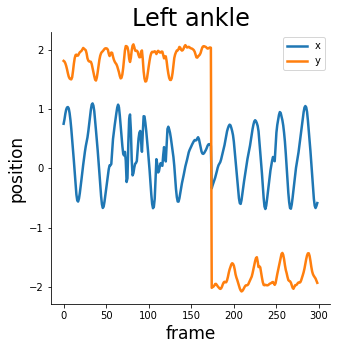

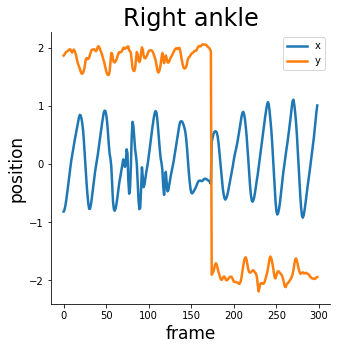

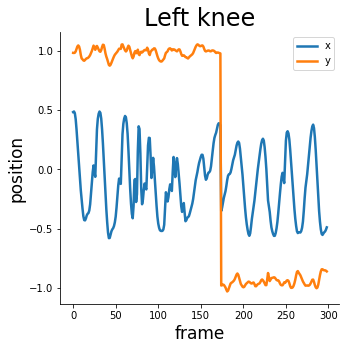

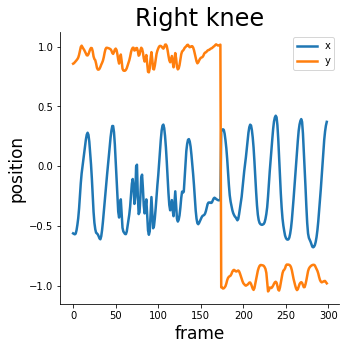

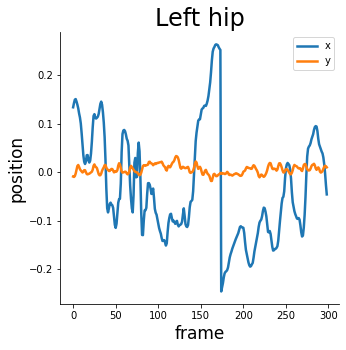

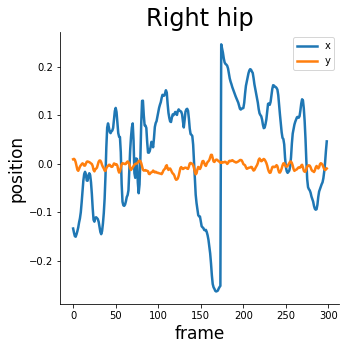

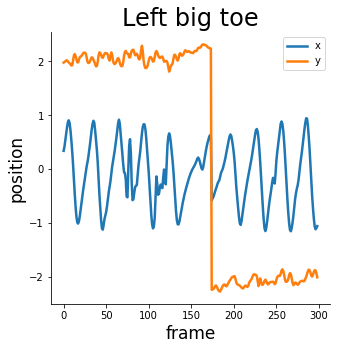

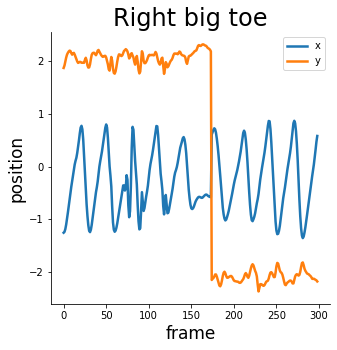

In [7]:
# plt.style.use('dark_background') # theme for matching the generated video with black bg

for name, col in PLOT_COLS.items():
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.title(name,fontsize=24)
    plt.xlabel("frame",fontsize=17)
    plt.ylabel("position",fontsize=17)

# colors for the dark theme (video)
#     color = [0.5]*3
#     if LANK == col:
#         color = [x/255. for x in [0,85,255]]
#     if RHIP == col:
#         color = [x/255. for x in [0,255,85]]
#     plt.plot(centered_filtered[:,[col*2,]], linestyle="-", color=color, linewidth=2.5)
#     plt.plot(centered_filtered[:,[col*2+1,]], linestyle="-", color=[min((x+0.1)*2,1) for x in color], linewidth=2.5)

    plt.plot(centered_filtered[:,[col*2,]], linestyle="-", linewidth=2.5)
    plt.plot(centered_filtered[:,[col*2+1,]], linestyle="-", linewidth=2.5)
    plt.legend(['x', 'y'],loc=1)
    
#     plt.savefig("plots/%d" % col, bbox_inches="tight") # save for the video

The big discontinouity around the friame 170 corresponds to the change of the orientation of the video. We mirror videos so that they all seem to have a person walking from right to left.

## Predicting gait parameters

With preprocessed data we are finally ready to run predition models. First, we define a function that takes a preprocessed multivariate time series data and runs a selected model.

In [8]:
def get_prediction(centered_filtered, col, side = None):
    model = load_model("models/{}_best.pb".format(col))
    correction_model = OLSResults.load("models/{}_correction.pb".format(col))

    maps = {
        "KneeFlex_maxExtension": (-29.4408212510502, 114.8431545843835),
        # "GDI": (32.5990731990764, 80.74813196013362), # doublesided
        "GDI": (36.314492983907, 77.03271217530302), # singlesided
        "gmfcs": (1, 3),
        "speed": (0.0718863507111867, 1.5259117583433834),
        "cadence": (0.222, 1.71556665023985),
        "SEMLS_dev_residual": (-0.8205001909638112, 3.309054961371647)
    }

    def undo_scaling(y,target_min,target_range):
        return y*target_range+target_min

    preds = []

    video_len = centered_filtered.shape[0]
    
    cols = x_columns
    if side == "L":
        cols = x_columns_left
    if side == "R":
        cols = x_columns_right

    samples = []
    for nstart in range(0,video_len-124,31):
        samples.append(centered_filtered[nstart:(nstart+124),cols])
    X = np.stack(samples)
    
    p = model.predict(X)[:,0]
    p = undo_scaling(p, maps[col][0], maps[col][1])
    p = np.transpose(np.vstack([p,np.ones(p.shape[0])]))
    p = correction_model.predict(pd.DataFrame(p))
    
    return np.mean(p)

Next, we define a function which will run all models from the paper one by one:

In [9]:
def get_all_preds(centered_filtered):
    cols = ["GDI","gmfcs","speed","cadence","SEMLS_dev_residual"]
    return dict([
        ("KneeFlex_maxExtension_L", get_prediction(centered_filtered, "KneeFlex_maxExtension", "L")),
        ("KneeFlex_maxExtension_R", get_prediction(centered_filtered, "KneeFlex_maxExtension", "R")),
    ] + [(col, get_prediction(centered_filtered, col)) for col in cols])

Finally, we run all models on our data:

In [10]:
get_all_preds(centered_filtered)

/home/kidzik/miniconda3/envs/gait-video/lib/python3.8/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


{'KneeFlex_maxExtension_L': 3.161832230057661,
 'KneeFlex_maxExtension_R': 0.6576527770684554,
 'GDI': 92.58603246872774,
 'gmfcs': 1.141023677636613,
 'speed': 1.1256748284724227,
 'cadence': 0.9892321616087401,
 'SEMLS_dev_residual': -0.3500216733152765}